Evaluate the performance of fitting GLiMMIRS-base to simulated data. In this example, we'll look at GLiMMIRS-base models fit to simulated data using the perturbation probability $X_{perturb}$ (as opposed to an indicator variable), calculated from "true" guide efficiencies (as opposed to noisy guide efficiencies). 

In [40]:
library(rhdf5)
library(ggplot2)
library(dplyr)
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

# Load data

Let's start by loading some data from the fitted GLiMMIRS-base models. Here, we're loading the coefficient estimates from fitting GLiMMIRS-base for the alternative hypothesis ($H_A: \beta_{enhancer}\neq0$) to simulated data. In this example, the simulated data was fit using the following simulation parameters:
- 50000 cells
- 13000 genes
- $\lambda=15$ (parameterizes Poisson distribution for determining number of unique gRNAs per cell
- 1000 unique genes whose enhancers are targeted 
- 2 gRNAs per target enhancer

We fit GLiMMIRS-base to the targeted genes - that is, genes whose enhancers were targeted by a gRNA in the simulated experiment. Here, we will load the table summarizing the estimated coefficient values from fitting GLiMMIRS-base to the simulated data for each of the targeted genes. 

In [6]:
alt.coeffs <- read.csv("/iblm/netapp/data1/jezhou/crisprQTL/GLiMMIRS-base_sim_performance/alt_coeffs.csv")

In [8]:
head(alt.coeffs)

,term,estimate,true,gene,targeting
,<chr>,<dbl>,<dbl>,<int>,<lgl>
1,(Intercept),0.3442158,0.1392011,9888,TRUE
2,guide.eff,-2.0835892,-2.3954196,9888,TRUE
3,s.score,3.0034209,3.4257021,9888,TRUE
4,g2m.score,2.3243046,2.6136613,9888,TRUE
5,percent.mito,3.3104483,4.1946477,9888,TRUE
6,(Intercept),1.9936354,1.9429977,7985,TRUE


# Comparing null vs. alternative hypotheses

We also saved the fitted models for both the null ($H_0: \beta_{enhancer}=0$) and the alternative hypotheses as lists to .rds files. Let's load them here:

In [9]:
null.mods <- readRDS("/iblm/netapp/data1/jezhou/crisprQTL/GLiMMIRS-base_sim_performance/null_ml.rds")
alt.mods <- readRDS("/iblm/netapp/data1/jezhou/crisprQTL/GLiMMIRS-base_sim_performance/alt_ml.rds")

Each `null.mods` and `alt.mods` is a named list, with the name corresponding to the target gene identifier. A given model `i` in each list should correspond to the same gene.

In [17]:
# check that named lists have same names
all(names(null.mods) == names(alt.mods))

[1] TRUE

In [18]:
# check to see that we have the same number of null and alt fitted mods
all(length(null.mods) == length(alt.mods))

[1] TRUE

One way to compare the null vs. alternative models is to examine the AIC scores. A lower AIC score indicates a better model fit. Here, we only modeled genes whose enhancers are targeted by a gRNA in our simulated experiment. Therefore, we would expect that $H_A$ yields a better fitting model than $H_0$. Let's check if that's the case:

In [19]:
null.mods[[1]]$aic

[1] 29511.97

In [20]:
n.correct <- 0

for (i in 1:length(null.mods)) {
    if (alt.mods[[i]]$aic < null.mods[[i]]$aic) {
        n.correct <- n.correct + 1
    }
}

print(paste(100*(n.correct/length(null.mods)), "% correct"))

[1] "98.8 % correct"


We could also check to see if the p-value of the $\beta_{enhancer}$ coefficient (named `guide.eff` in the fitted model) is significant ($p<0.05$ after multiple testing correction) in the fitted alternative model:

In [27]:
beta.enh.pvals <- as.numeric(length(alt.mods))

for (i in 1:length(alt.mods)) {
    p <- (summary(alt.mods[[i]])$coefficients[,4])['guide.eff']
    beta.enh.pvals[i] <- p
}

In [32]:
print(paste(100*(sum(p.adjust(beta.enh.pvals, method = "fdr")<0.05)/length(alt.mods)), "% of cases have significant coefficient"))

[1] "98.9 % of cases have significant coefficient"


# Correlation 

To begin, let's calculate the Pearson correlation between the true and estimated coefficients for every term across all of the targeted genes. 

In [35]:
alt.coeffs %>% mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito"))) %>% 
                    group_by(term) %>% 
                        summarise(r = cor.test(true, estimate, method = "pearson")$estimate,
                                p_val = cor.test(true, estimate, method = "pearson")$p.value)

term,r,p_val
<fct>,<dbl>,<dbl>
(Intercept),0.9960927,0.000000e+00
guide.eff,0.8514912,4.672139e-282
s.score,0.9694676,0.000000e+00
g2m.score,0.9800856,0.000000e+00
percent.mito,0.9027987,0.000000e+00


# Coefficient of determination
We can also calculate the coefficient of determination ($R^2$), which is a measure of how well the model predicts:


In [37]:
alt.coeffs %>% mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito"))) %>% 
                    group_by(term) %>% summarise(R2 = 1-(sum((true-estimate)^2)/sum((true-mean(true))^2)))

term,R2
<fct>,<dbl>
(Intercept),0.9855486
guide.eff,0.6361300
s.score,0.9253488
g2m.score,0.9506913
percent.mito,0.7787371


# Visualize

Finally, let's plot the ground truth vs. estimated coefficient estimates for the alternative model:

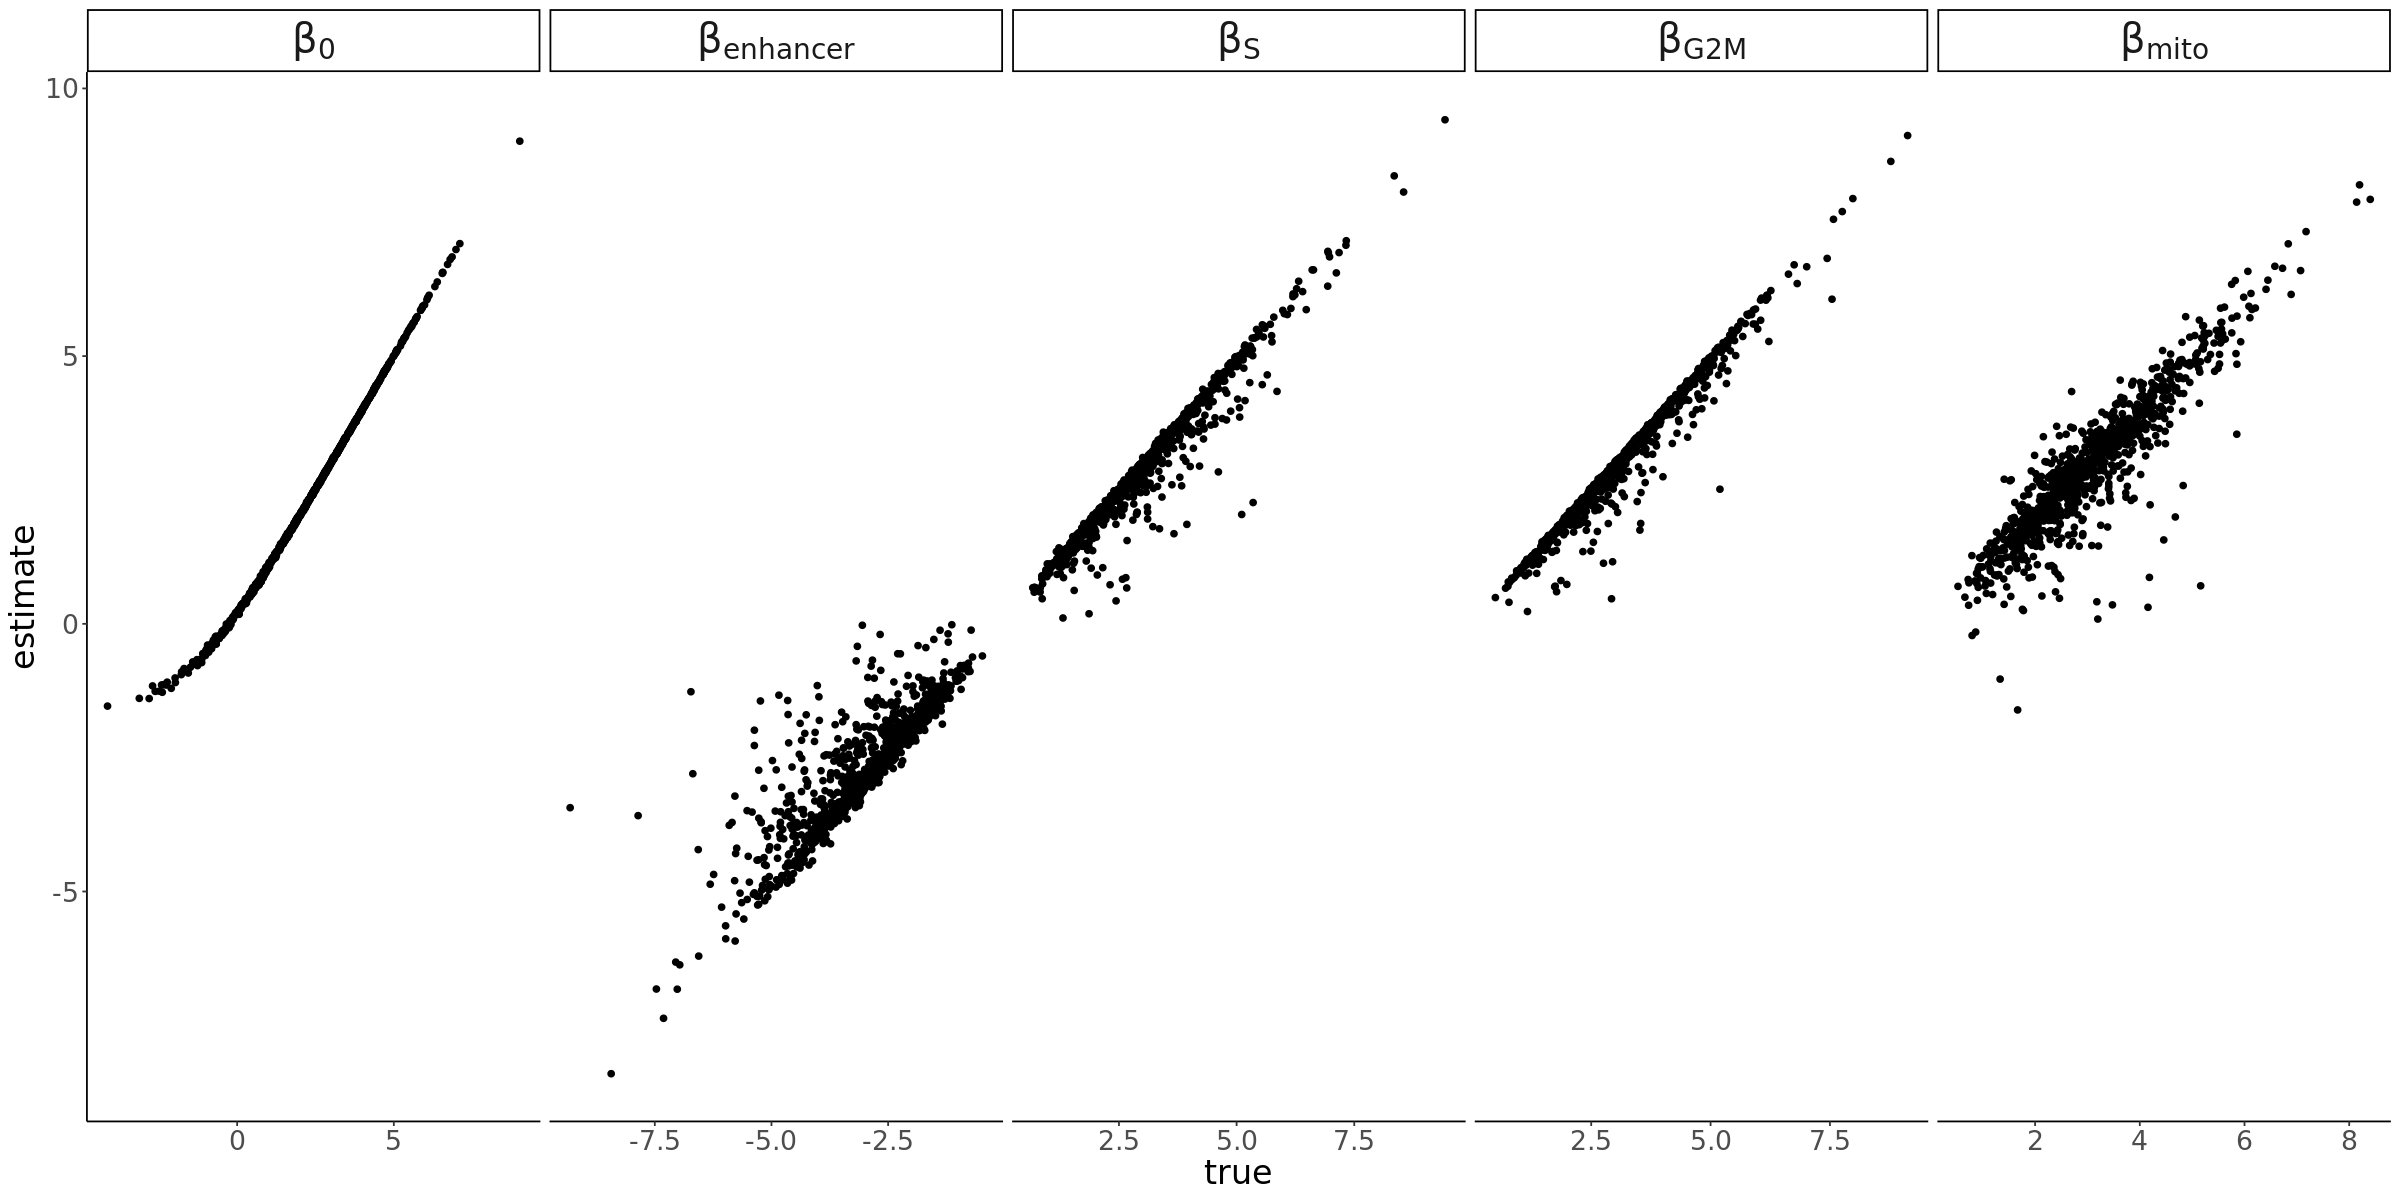

In [53]:
ggplot(alt.coeffs %>% 
        mutate(across(term, factor, levels=c("(Intercept)","guide.eff","s.score","g2m.score","percent.mito"))) %>%
              mutate(coeff = recode(term,
                "(Intercept)" = "{beta}[0]",
                "guide.eff" = "{beta}[enhancer]",
                "s.score" = "{beta}[S]",
                "g2m.score" = "{beta}[G2M]",
                "percent.mito" = "{beta}[mito]"
              )), aes(x = true, y = estimate)) + geom_point() + 
            facet_grid(cols = vars(coeff), scales = "free", labeller = label_parsed) +
            theme_classic() + theme(text = element_text(size = 20), strip.text = element_text(size = 24))